In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
import shutil
from tensorflow.keras.models import model_from_json

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):
    
    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
path = os.getcwd()
path

'/home/ubuntu/CNNCAP'


if not os.path.exists(path + "/Data"):
    os.mkdir(path + "/Data")
    os.mkdir(path + "/Data/Data")
    os.mkdir(path + "/Data/Labels")
    os.mkdir(path + "/Data/Labels/Tau_23")
    os.mkdir(path + "/Data/Labels/Tau_12")
    os.mkdir(path + "/Data/Labels/Tau_13")
else:
    shutil.rmtree(path + "/Data") #delete the folder
    os.mkdir(path + "/Data")
    os.mkdir(path + "/Data/Data")
    os.mkdir(path + "/Data/Labels")
    os.mkdir(path + "/Data/Labels/Tau_23")
    os.mkdir(path + "/Data/Labels/Tau_12")
    os.mkdir(path + "/Data/Labels/Tau_13")

In [5]:
all_taus = False

# 1. Generae Input datasets¶

In [6]:
subdirs = [subdir for subdir, dirs, files in os.walk(path + "/Capstone_Data")]
subdirs = subdirs[1:]
subdirs = subdirs[:1] + subdirs[2:]
subdirs

['/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse4',
 '/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse16',
 '/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse8',
 '/home/ubuntu/CNNCAP/Capstone_Data/.ipynb_checkpoints',
 '/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse24',
 '/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse24/.ipynb_checkpoints']

In [7]:
subdirs.remove('/home/ubuntu/CNNCAP/Capstone_Data/.ipynb_checkpoints')



subdirs.remove('/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse24/.ipynb_checkpoints')
subdirs

['/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse4',
 '/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse16',
 '/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse8',
 '/home/ubuntu/CNNCAP/Capstone_Data/Re15sh20_DNScoarse24']

counter = 1
size = 3
ini = 0
name = ['_DNS4.mat','_DNS16.mat','.mat','_DNS24.mat']
for directory in subdirs:
    temp = directory.split("/")[-1]
    os.chdir(path + "/Capstone_Data/" + temp)
    print("Reading: " + temp)
    
    # Load data and check its shape
    uname = 'u_F_xyz_T1'+name[ini]
    vname = 'v_F_xyz_T1'+name[ini]
    wname = 'w_F_xyz_T1'+name[ini]
    tau1na = 'tau12_xyz_T1'+name[ini]
    tau2na = 'tau13_xyz_T1'+name[ini]
    tau3na = 'tau23_xyz_T1'+name[ini]
    u = preprocess(scale(loadmat(uname)["u_F"]))
    v = preprocess(scale(loadmat(vname)["v_F"]))
    w = preprocess(scale(loadmat(wname)["w_F"]))
    tau_12 = preprocess(scale(loadmat(tau1na)["tau12"]))
    tau_13 = preprocess(scale(loadmat(tau2na)["tau13"]))
    tau_23 = preprocess(scale(loadmat(tau3na)["tau23"]))
    print("Data Shape: " + str(u.shape))
    
    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3, 0])
    x = np.pad(x, ((size,size), (size,size), (size,size), (0,0)), 'constant', constant_values = 0)
    del u
    del v
    del w
    gc.collect()
    
    sample = []
    y_tau_23 = []
    y_tau_12 = []
    y_tau_13 = []
    num_files = 10

    x_range = np.arange(size, x.shape[0] - size)
    np.random.shuffle(x_range)
    y_range = np.arange(size, x.shape[1] - size)
    np.random.shuffle(y_range)
    z_range = np.arange(size, x.shape[2] - size)
    np.random.shuffle(z_range)
    for i in x_range:
        for j in y_range:
            for k in z_range:
                sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_tau_23.append(tau_23[i - size][j - size][k - size])
                y_tau_12.append(tau_12[i - size][j - size][k - size])
                y_tau_13.append(tau_13[i - size][j - size][k - size])

                if len(sample) == int(((x.shape[0] - size * 2) * (x.shape[1] - size * 2) * (x.shape[2] - size * 2)) / num_files):
                    os.chdir(path + "/Data/Data")
                    np.save(str(counter), np.array(sample))
                    os.chdir(path + "/Data/Labels/Tau_23")
                    np.save(str(counter), np.array(y_tau_23))
                    os.chdir(path + "/Data/Labels/Tau_12")
                    np.save(str(counter), np.array(y_tau_12))
                    os.chdir(path + "/Data/Labels/Tau_13")
                    np.save(str(counter), np.array(y_tau_13))

                    del sample
                    del y_tau_13
                    del y_tau_12
                    del y_tau_23
                    gc.collect()
                    sample = []
                    y_tau_23 = []
                    y_tau_12 = []
                    y_tau_13 = []
                    
                    counter += 1
    del x
    del tau_12
    del tau_13
    del tau_23
    gc.collect()
    print("Saved " + temp + " to disk\n")
    ini =ini+1

counter = 1
size = 3
ini = 0
name = ['_DNS4.mat','_DNS16.mat','.mat','_DNS24.mat']
for directory in subdirs:
    temp = directory.split("/")[-1]
    #os.chdir(path + "/Capstone_Data/" + temp)
    print("Reading: " + temp)
    
    # Load data and check its shape
    uname = 'u_F_xyz_T1'+name[ini]
    vname = 'v_F_xyz_T1'+name[ini]
    wname = 'w_F_xyz_T1'+name[ini]
    tau1na = 'tau12_xyz_T1'+name[ini]
    tau2na = 'tau13_xyz_T1'+name[ini]
    tau3na = 'tau23_xyz_T1'+name[ini]
    print(uname,vname,wname)
    ini = ini +1

# 2. Build Model¶

In [8]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, input_shape):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.input_shape = input_shape
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
counter = 1
size = 3
ini = 0
name = ['_DNS4.mat','_DNS16.mat','.mat','_DNS24.mat']
num_files = 10

# Run model

Box size used: (7, 7, 7, 3)

Predicting Tau_12
Final Dataset Correlation: 0.8672
CPU times: user 1h 15min 13s, sys: 54min 47s, total: 2h 10min 1s
Wall time: 1h 40min 4s


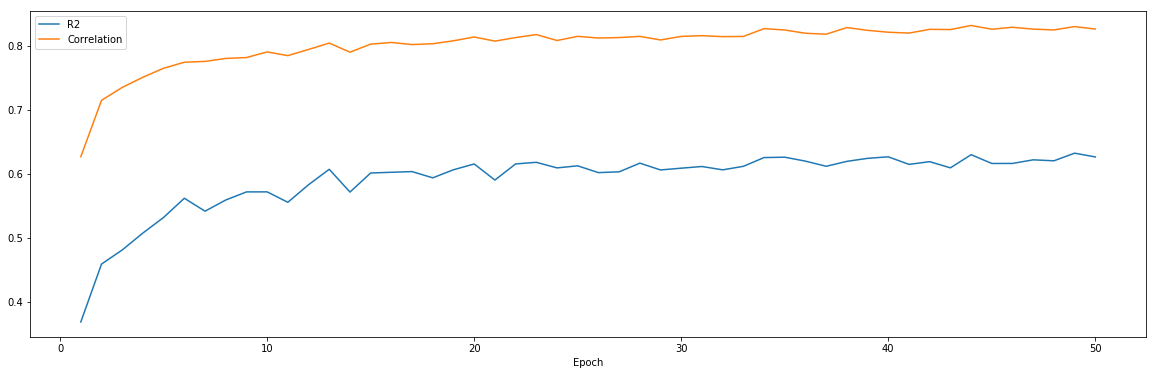

In [9]:
%%time
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
val_split = 0.2

datasets = ["Tau_12"]
results = {}
i = 1
k = 1
print("Box size used: " + str((2 * size + 1, 2 * size + 1, 2 * size + 1, 3)))
fig = plt.figure(figsize = (20, 6))
for name in datasets:
    x_test = []
    y_test = []
    print("\nPredicting " + name)
    input_shape = (2 * size + 1, 2 * size + 1, 2 * size + 1, 3)
    neural_net = DNN(activation, initializer, regularizer, input_shape)
    model = neural_net.create_model()
    model.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")
    correlation = []
    R2 = []
    for i in range(epochs):
        temp_1 = []
        temp_2 = []        
        files_range = np.arange(1, num_files * 4 + 1)
        np.random.shuffle(files_range)
        for j in files_range:
            # Load Datasets
            x = np.load(path + "/Data/Data/" + str(j) + ".npy")
            y = np.load(path + "/Data/Labels/" + name + "/" + str(j) + ".npy")
            
            # Create Train and Test sets
            mask =  np.random.rand(x.shape[0]) < 0.80
            x_train = x[mask,:,:,:,:]
            y_train = y[mask]
            x_test = x[~mask,:,:,:,:]
            y_test = y[~mask]
            del y
            del mask
            gc.collect()

            model.fit(x_train, y_train, epochs = 1, validation_split = 0.2, batch_size = batch_size, verbose = 0)
            del x_train
            del y_train
            gc.collect()
            
            # Get Test corr and R2 and append to list
            y_pred = model.predict(x_test).flatten()
            gc.collect()
            y_true = y_test.flatten()
            temp_1.append(r2_score(y_true, y_pred))
            temp_2.append(np.corrcoef(y_pred, y_true)[0, 1])
            del x_test
            del y_test
            del x
            gc.collect()
            i += 1
        
        # Get average Test corr and R2 for the epoch
        correlation.append(np.mean(temp_2))
        R2.append(np.mean(temp_1))
    
    # Plot R2 and corr evolution
    fig.add_subplot(1, len(datasets), k)
    plt.plot(np.arange(1, epochs + 1), np.array(R2), label = 'R2')
    plt.plot(np.arange(1, epochs + 1), np.array(correlation), label = 'Correlation')
    plt.xlabel('Epoch')
    plt.legend()
    print("Final Dataset Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    del y_pred
    del y_true
    gc.collect()
    
    k += 1

Box size used: (7, 7, 7, 3)

Predicting Tau_13
Final Dataset Correlation: 0.8596
CPU times: user 1h 20min 47s, sys: 54min 51s, total: 2h 15min 39s
Wall time: 1h 46min 30s


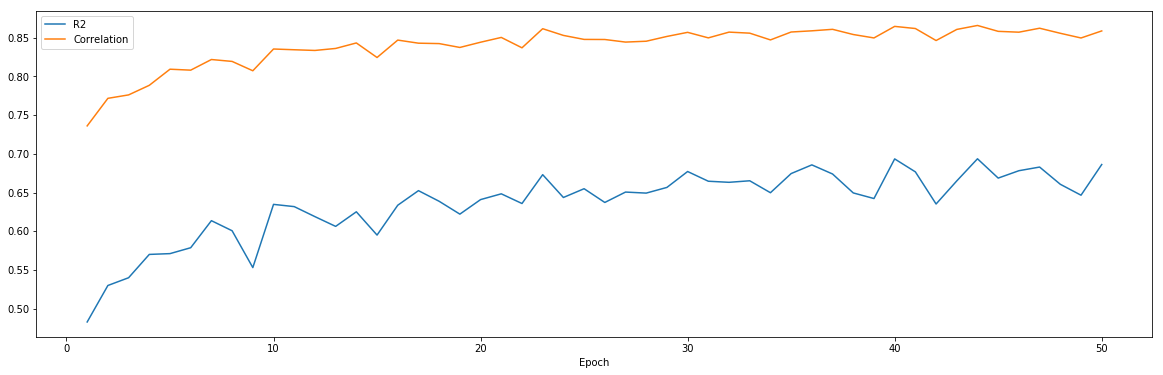

In [12]:
%%time
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
val_split = 0.2

datasets = ["Tau_13"]
results = {}
i = 1
k = 1
print("Box size used: " + str((2 * size + 1, 2 * size + 1, 2 * size + 1, 3)))
fig = plt.figure(figsize = (20, 6))
for name in datasets:
    x_test = []
    y_test = []
    print("\nPredicting " + name)
    input_shape = (2 * size + 1, 2 * size + 1, 2 * size + 1, 3)
    neural_net = DNN(activation, initializer, regularizer, input_shape)
    model = neural_net.create_model()
    model.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")
    correlation = []
    R2 = []
    for i in range(epochs):
        temp_1 = []
        temp_2 = []        
        files_range = np.arange(1, num_files * 4 + 1)
        np.random.shuffle(files_range)
        for j in files_range:
            # Load Datasets
            x = np.load(path + "/Data/Data/" + str(j) + ".npy")
            y = np.load(path + "/Data/Labels/" + name + "/" + str(j) + ".npy")
            
            # Create Train and Test sets
            mask =  np.random.rand(x.shape[0]) < 0.80
            x_train = x[mask,:,:,:,:]
            y_train = y[mask]
            x_test = x[~mask,:,:,:,:]
            y_test = y[~mask]
            del y
            del mask
            gc.collect()

            model.fit(x_train, y_train, epochs = 1, validation_split = 0.2, batch_size = batch_size, verbose = 0)
            del x_train
            del y_train
            gc.collect()
            
            # Get Test corr and R2 and append to list
            y_pred = model.predict(x_test).flatten()
            gc.collect()
            y_true = y_test.flatten()
            temp_1.append(r2_score(y_true, y_pred))
            temp_2.append(np.corrcoef(y_pred, y_true)[0, 1])
            del x_test
            del y_test
            del x
            gc.collect()
            i += 1
        
        # Get average Test corr and R2 for the epoch
        correlation.append(np.mean(temp_2))
        R2.append(np.mean(temp_1))
    
    # Plot R2 and corr evolution
    fig.add_subplot(1, len(datasets), k)
    plt.plot(np.arange(1, epochs + 1), np.array(R2), label = 'R2')
    plt.plot(np.arange(1, epochs + 1), np.array(correlation), label = 'Correlation')
    plt.xlabel('Epoch')
    plt.legend()
    print("Final Dataset Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    del y_pred
    del y_true
    gc.collect()
    
    k += 1

Box size used: (7, 7, 7, 3)

Predicting Tau_23
Final Dataset Correlation: 0.8304
CPU times: user 1h 23min 34s, sys: 52min 34s, total: 2h 16min 8s
Wall time: 1h 46min 59s


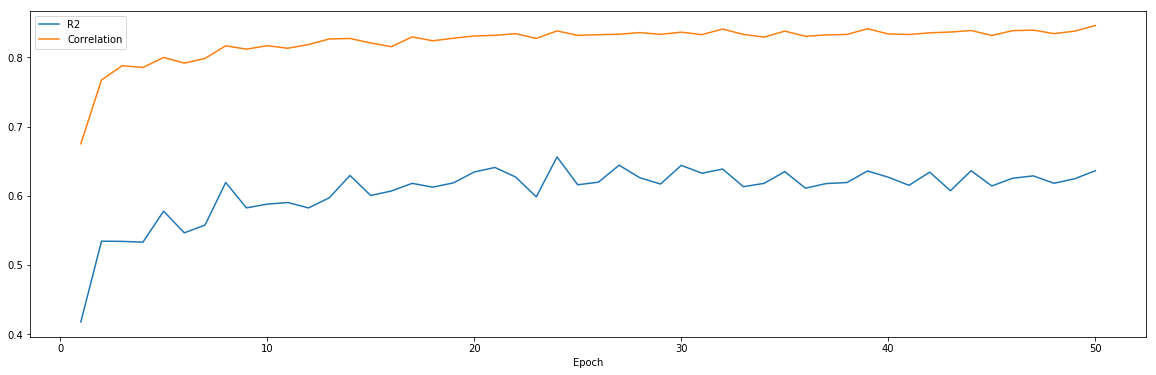

In [13]:
%%time
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
val_split = 0.2

datasets = ["Tau_23"]
results = {}
i = 1
k = 1
print("Box size used: " + str((2 * size + 1, 2 * size + 1, 2 * size + 1, 3)))
fig = plt.figure(figsize = (20, 6))
for name in datasets:
    x_test = []
    y_test = []
    print("\nPredicting " + name)
    input_shape = (2 * size + 1, 2 * size + 1, 2 * size + 1, 3)
    neural_net = DNN(activation, initializer, regularizer, input_shape)
    model = neural_net.create_model()
    model.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")
    correlation = []
    R2 = []
    for i in range(epochs):
        temp_1 = []
        temp_2 = []        
        files_range = np.arange(1, num_files * 4 + 1)
        np.random.shuffle(files_range)
        for j in files_range:
            # Load Datasets
            x = np.load(path + "/Data/Data/" + str(j) + ".npy")
            y = np.load(path + "/Data/Labels/" + name + "/" + str(j) + ".npy")
            
            # Create Train and Test sets
            mask =  np.random.rand(x.shape[0]) < 0.80
            x_train = x[mask,:,:,:,:]
            y_train = y[mask]
            x_test = x[~mask,:,:,:,:]
            y_test = y[~mask]
            del y
            del mask
            gc.collect()

            model.fit(x_train, y_train, epochs = 1, validation_split = 0.2, batch_size = batch_size, verbose = 0)
            del x_train
            del y_train
            gc.collect()
            
            # Get Test corr and R2 and append to list
            y_pred = model.predict(x_test).flatten()
            gc.collect()
            y_true = y_test.flatten()
            temp_1.append(r2_score(y_true, y_pred))
            temp_2.append(np.corrcoef(y_pred, y_true)[0, 1])
            del x_test
            del y_test
            del x
            gc.collect()
            i += 1
        
        # Get average Test corr and R2 for the epoch
        correlation.append(np.mean(temp_2))
        R2.append(np.mean(temp_1))
    
    # Plot R2 and corr evolution
    fig.add_subplot(1, len(datasets), k)
    plt.plot(np.arange(1, epochs + 1), np.array(R2), label = 'R2')
    plt.plot(np.arange(1, epochs + 1), np.array(correlation), label = 'Correlation')
    plt.xlabel('Epoch')
    plt.legend()
    print("Final Dataset Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    del y_pred
    del y_true
    gc.collect()
    
    k += 1